# 1. Business Understanding

Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель.<br>
Приблизить - разбить временной ряд на train и test, предсказать для моментов времени test, используя только данные train, а также измерить качество предсказания

# 2. Data Understanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [2]:
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [3]:
def tsplot(y, q, lags=None, figsize=(8, 3), style='bmh'):
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (q, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        y.plot(ax=ts_ax, color='red', label='Or')
        ts_ax.set_title(key,fontsize=12)
    return

In [4]:
all_series = {
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Daily total female births in California": female_births["Count"],
    }

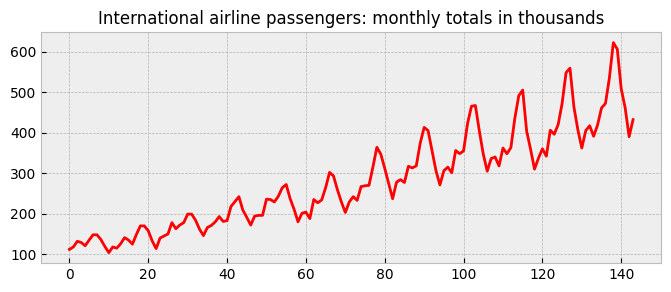

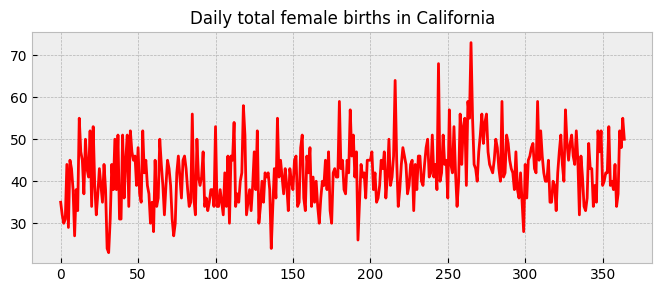

In [5]:
q = (len(all_series))
for key in all_series.keys():   
    tsplot(all_series[key], q)

# 3. Data Preparation

# 4. Modeling

### Daily total female births in California

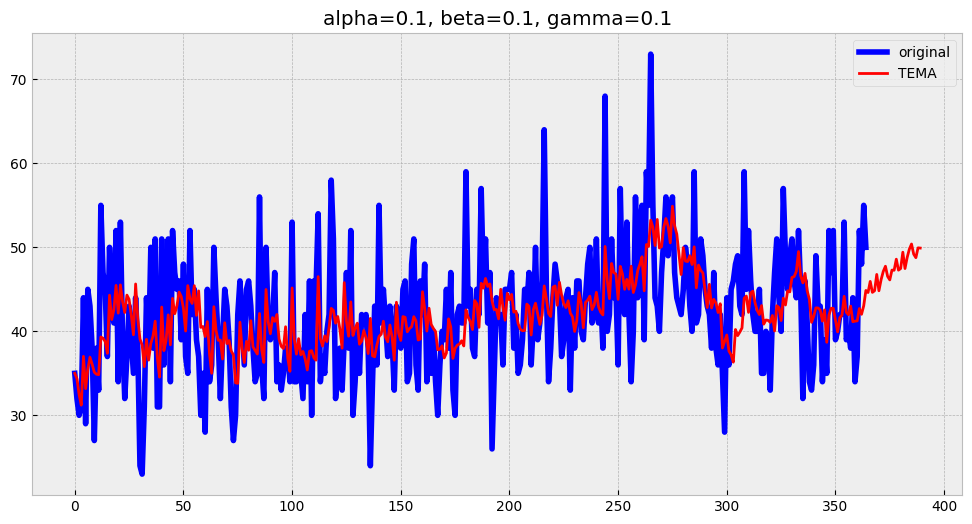

In [178]:
series1 = all_series["Daily total female births in California"]
i=12
def initial_trend(series1, season_len):
    return sum([float(series1[i + season_len] - series1[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series1)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series1[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series1[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series1, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series1, slen)
    for i in range(len(series1)+n_preds):
        if i == 0: # initial values
            smooth = series1[0]
            trend = initial_trend(series1, slen)
            result.append(series1[0])
            continue
        if i >= len(series1): # we are forecasting
            m = i - len(series1) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series1[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

def plot_tema(alpha, beta, gamma, ser=series1, ser_to_plot=series1, n_preds=25):
    tema = triple_exponential_smoothing(series1, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(12, 6))
        plt.plot(ser_to_plot, color='blue',linewidth='4', label='original')
        plt.plot(tema, color='red', linewidth='2', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()
# alpha_opt, beta_opt, gamma_opt 
plot_tema(0.1, 0.1, 0.1)

310 365
      fun: 43.307710447756016
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.69068963e+01, -1.42108547e-06, -0.00000000e+00])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 36
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([1.        , 0.01552822, 1.        ])


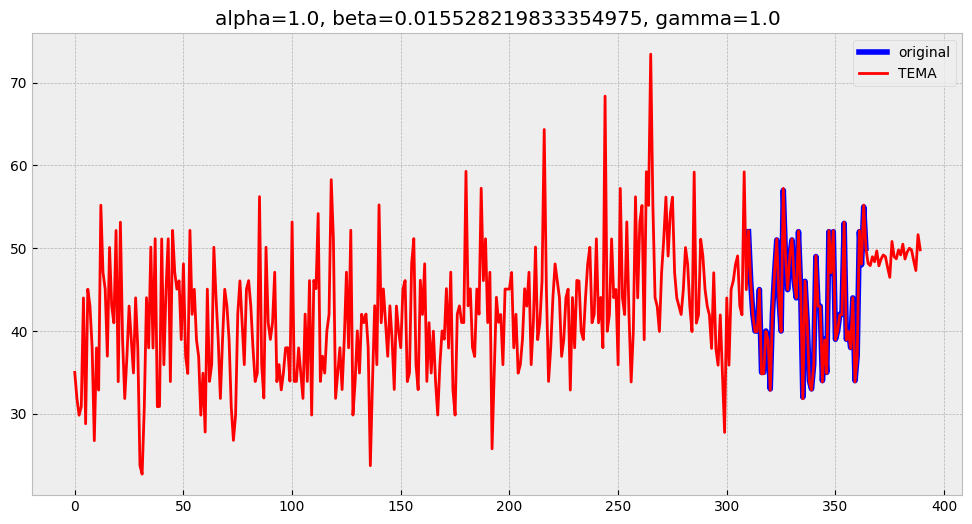

In [179]:
train_perc1 = 85
test_perc1 = 100 - train_perc1
train_ind1 =int(len(series1)*train_perc1/100)
total_ind1 = len(series1)
print(train_ind1, total_ind1)
train1, test1, = series1[:train_ind1], series1[train_ind1:total_ind1]

def mse(X1):
    alpha1, beta1, gamma1 = X1
    result1 = triple_exponential_smoothing(train1, 12, alpha1, beta1, gamma1, len(test1))
    predictions1 = result1[-len(test1):]
    error = mean_squared_error(predictions1, test1)
    return error

opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt1, beta_opt1, gamma_opt1 = opt.x
plot_tema(alpha_opt1, beta_opt1, gamma_opt1, ser=test1, ser_to_plot=test1, n_preds=25)
print(opt)

### International airline passengers: monthly totals in thousands

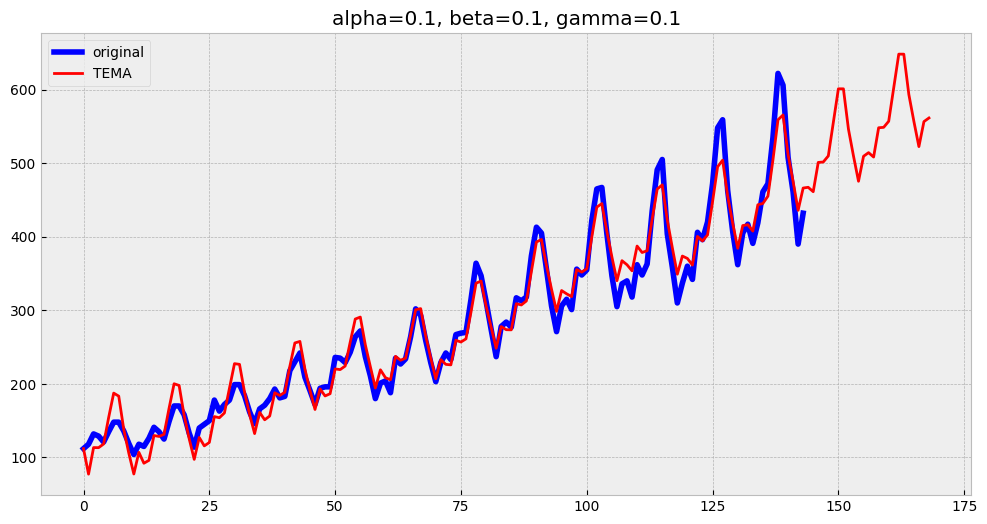

In [176]:
series2 = all_series["International airline passengers: monthly totals in thousands"]
i=12
def initial_trend(series2, season_len):
    return sum([float(series2[i + season_len] - series2[i]) / season_len]) / season_len

def initial_seasonal_components(series2, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series2)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series2[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series2[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series2)+n_preds):
        if i == 0: # initial values
            smooth = series2[0]
            trend = initial_trend(series2, slen)
            result.append(series2[0])
            continue
        if i >= len(series2): # we are forecasting
            m = i - len(series2) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series2[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

def plot_tema(alpha, beta, gamma, ser=series2, ser_to_plot=series2, n_preds=25):
    tema = triple_exponential_smoothing(series2, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(12, 6))
        plt.plot(ser_to_plot, color='blue',linewidth='4', label='original')
        plt.plot(tema, color='red', linewidth='2', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()
# alpha_opt, beta_opt, gamma_opt 
plot_tema(0.1, 0.1, 0.1)

108 144
      fun: 3239.842226146742
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.01705303, 0.83650775, 0.00632099])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 120
      nit: 21
     njev: 30
   status: 0
  success: True
        x: array([8.58341328e-01, 2.95085634e-04, 7.73845254e-02])


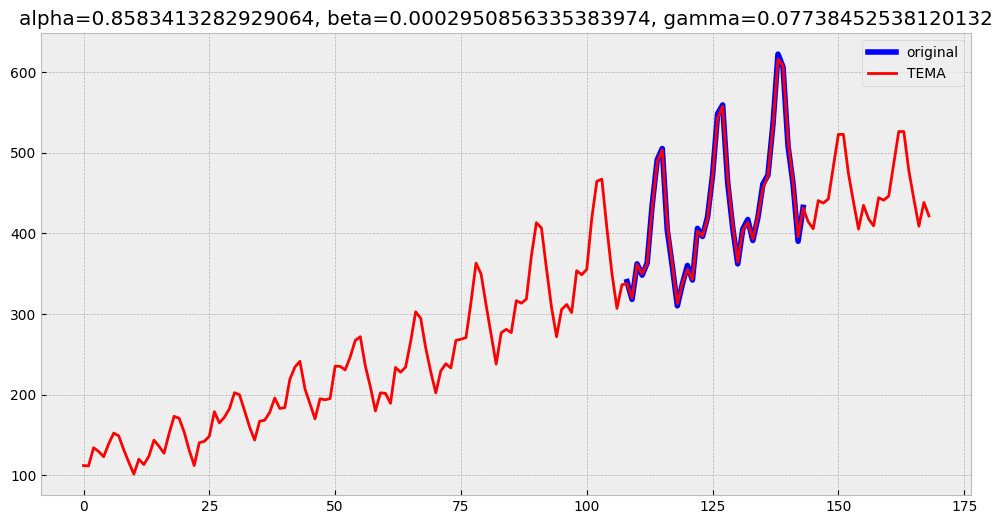

In [175]:
train_perc2 = 75
test_perc2 = 100 - train_perc2
train_ind2 =int(len(series2)*train_perc2/100)
total_ind2 = len(series2)
print(train_ind2, total_ind2)
train2, test2, = series2[:train_ind2], series2[train_ind2:total_ind2]

def mse(X2):
    alpha2, beta2, gamma2 = X2
    result2 = triple_exponential_smoothing(train2, 12, alpha2, beta2, gamma2, len(test2))
    predictions2 = result2[-len(test2):]
    error = mean_squared_error(predictions2, test2)
    return error

opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt2, beta_opt2, gamma_opt2 = opt.x
plot_tema(alpha_opt2, beta_opt2, gamma_opt2, ser=test2, ser_to_plot=test2, n_preds=25)
print(opt)

# 5. Evaluation

# 6. Deployment